In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data
For more details on how data is loaded, please see `subroutines.py`.

In [2]:
def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive', alpha=0.3)
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative', alpha=0.3)
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

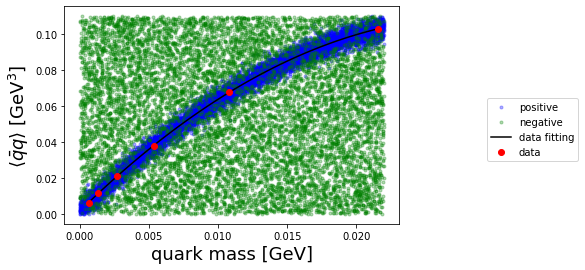

In [3]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=10000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [4]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [5]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [15]:
# def phi_one_step(phi=None, Pi=None, del_eta=None):
#     ''' phi's eta evolution '''
#     return phi + del_eta*Pi 

# def Pi_one_step(phi=None, Pi=None, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Pi's eta evolution '''
#     return Pi +(-1)*del_eta*(Pi_W - phi_m2 - phi3_lam)

# def one_step(phi, Pi, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Evolutions both phi and Pi '''
#     phi2 = phi_one_step(phi, Pi, del_eta)
#     Pi2 = Pi_one_step(phi, Pi, Pi_W=Pi_W, phi_m2=phi_m2, phi3_lam = phi3_lam, del_eta=del_eta)
#     return phi2, Pi2

def onestep(phi, Pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*Pi
    Pi1 = phi*m2*del_eta + (1-del_eta*hh)*Pi + del_eta*lamb*(phi1**3)
    return phi1, Pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, Pi, eta=None):
    ''' returning Pi'''
    F=Pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

##### 

class MetricNet(nn.Module):
    ''' class of model to be trained '''
    def __init__(self, Number_of_layers=None, eta_ini=None, eta_fin=None, m2=None, del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(Number_of_layers):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layers = Number_of_layers
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d

    def show_lamb(self):
        return self.lamb(self.one)
    
    def show_adsradius(self):
        return self.adsradius(self.one)
        
    def penalty(self, coef_list=None):
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layers))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        for i in range(self.N_layers):
            H = self.Hs[i]
            if H==self.Hs[0]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = 0.01*(self.d - H(self.one))**2
                pH = H(self.one)
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
        
    def forward(self, phi=None, Pi=None):
        ''' forward propagation '''
        # initial layer
        alphatilde = self.adsradius(self.one)*(1.7320508/(2*3.1415926))*phi
        betatilde = (self.adsradius(self.one))**3*(3.1415926/1.7320508)*Pi
        phi = alphatilde*(np.exp(-self.eta_ini)) + betatilde*(np.exp(-3*self.eta_ini)) -(1/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        Pi = -alphatilde*(np.exp(-self.eta_ini)) -3*betatilde*(np.exp(-3*self.eta_ini)) +(3/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))-(1/2)*alphatilde**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        # intermediate layers
        for H in self.Hs:
            phi, Pi = onestep(phi, Pi, hh=H(self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        # finaly layer
        f_ = f(phi, Pi, eta=eta(self.N_layers, self.eta_ini, self.eta_fin, self.N_layers))
        final = t(f_, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model, d):
    ''' for initializations of parameters '''
    # metric (H[layer])
    for i in range(len(Model.Hs)):
        # ipt = initial value for H[i]
        ipt = d
        # noize 
        std = 3
        w = np.random.normal(ipt, std) # sampling from Gaussian
        w = round(w, 10) # it seems to be needed to round w somehow, I don't know why...
        Model.Hs[i].weight.data.fill_(w) # initialization excuted 
    
    # lambda
    lamb = 0.2
    std = 0
    lamb = np.random.normal(lamb, std)
    Model.lamb.weight.data.fill_(lamb)
    
    # AdS radius[GeV^{-1}]
    adsradius = 0.8
    std = 0
    adsradius = np.random.normal(adsradius, std)
    Model.adsradius.weight.data.fill_(adsradius)

In [16]:
# parameters
d = 4
m2 = -3 # mass^2
N_layer = 15
Delta_plus = d/2 +1
Delta_minus= d/2 -1
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
# making network
Test = MetricNet(Number_of_layers=N_layer, 
                         eta_ini=eta_ini, 
                         eta_fin=eta_fin,
                         m2=m2, 
                         del_eta=del_eta,
                         d=d)
init_weights(Test, d)
# setting it to be trained
optimizer = optim.Adam(Test.parameters()) 
Test.train()
# For regularization terms
regularization_coeffs = [0] #(np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])*0.001).tolist()
for i in range(1, N_layer):
    regularization_coeffs.append(0.01*eta(i, eta_ini, eta_fin, N_layer)**4)

# 3. Train your NN

In [17]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 18
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=18)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    al.plot(positive_H , positive_M, '.', label='Positive', alpha=0.5)
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'o', label='NN(negative)=0', alpha=0.5)
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'o', label='NN(positive)=0', alpha=0.1)
    al.tick_params(labelsize=18)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=18)
    else:
        x = np.arange(0,Net.N_layers,1)
        ar.set_xlabel('layer', fontsize=18)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=18)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=18)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

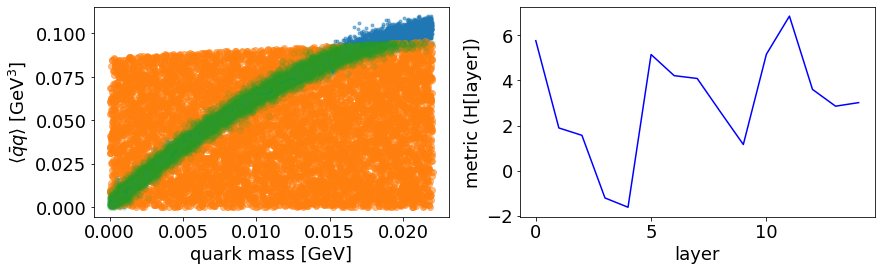

training epoch: 0,   loss: 0.6728050112724304
lambda: 0.37350013852119446,   AdS radius: 1.1098767518997192[1/GeV]


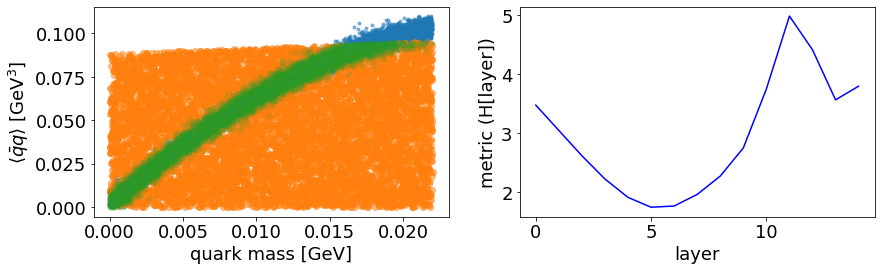

training epoch: 100,   loss: 0.2483309805393219
lambda: -3.40130877494812,   AdS radius: 1.036354660987854[1/GeV]


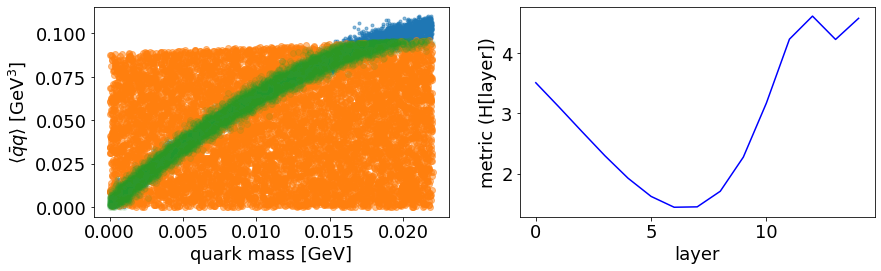

training epoch: 200,   loss: 0.2459910809993744
lambda: -6.816254615783691,   AdS radius: 1.1093003749847412[1/GeV]


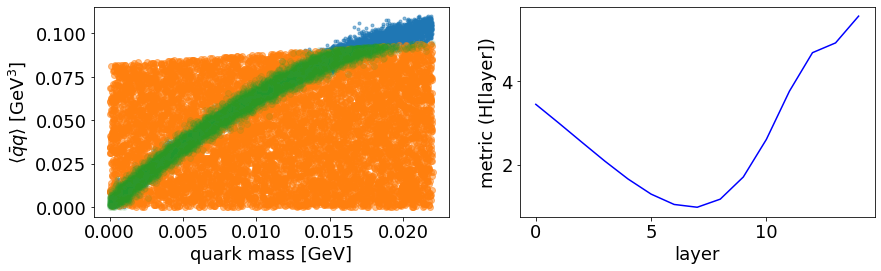

training epoch: 300,   loss: 0.24159181118011475
lambda: -10.245099067687988,   AdS radius: 1.332734227180481[1/GeV]


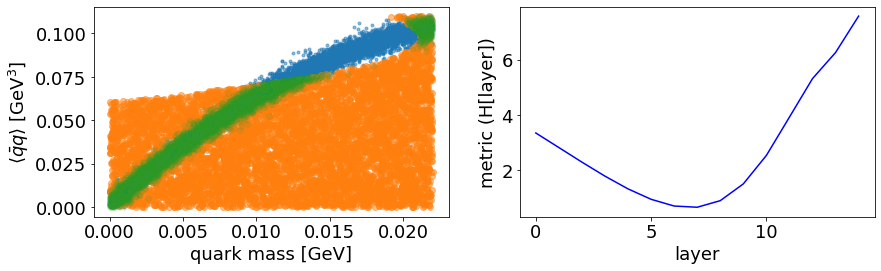

training epoch: 400,   loss: 0.22719784080982208
lambda: -11.128565788269043,   AdS radius: 1.6707228422164917[1/GeV]


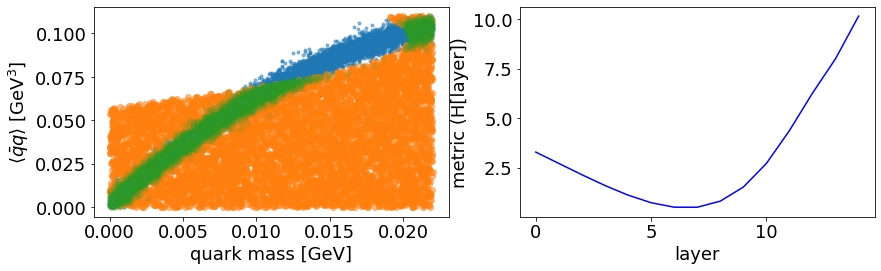

training epoch: 500,   loss: 0.21973834931850433
lambda: -10.884119033813477,   AdS radius: 1.6546611785888672[1/GeV]


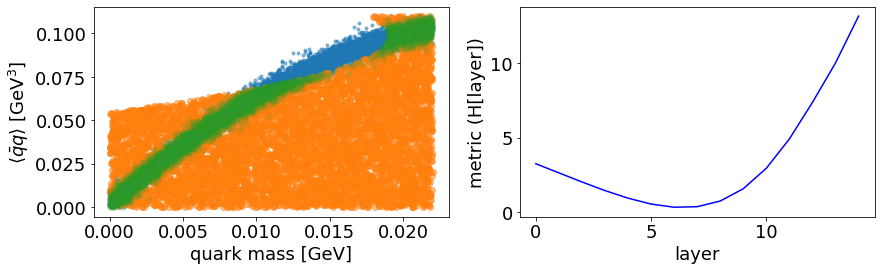

training epoch: 600,   loss: 0.21109165251255035
lambda: -10.483591079711914,   AdS radius: 1.637900710105896[1/GeV]


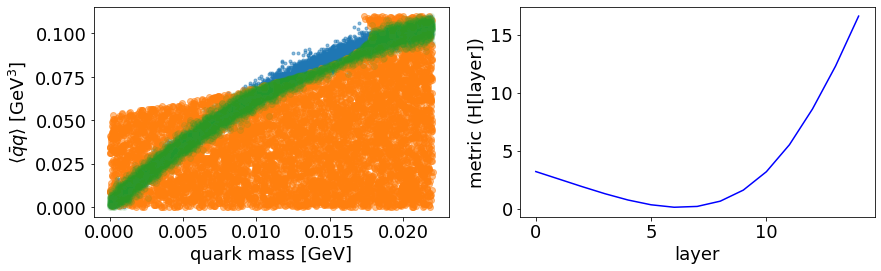

training epoch: 700,   loss: 0.20290164649486542
lambda: -9.879880905151367,   AdS radius: 1.6076565980911255[1/GeV]


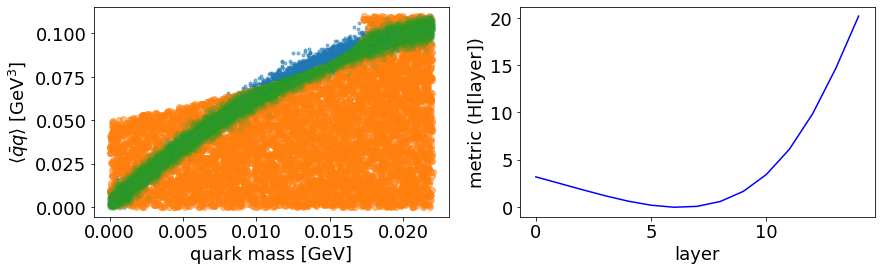

training epoch: 800,   loss: 0.19516071677207947
lambda: -9.09587574005127,   AdS radius: 1.5882980823516846[1/GeV]


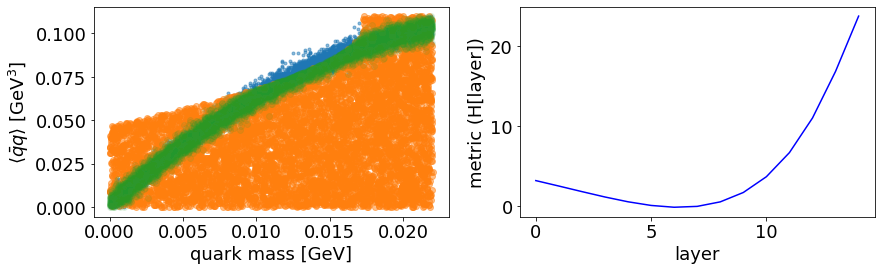

training epoch: 900,   loss: 0.1885877400636673
lambda: -8.138354301452637,   AdS radius: 1.5719233751296997[1/GeV]


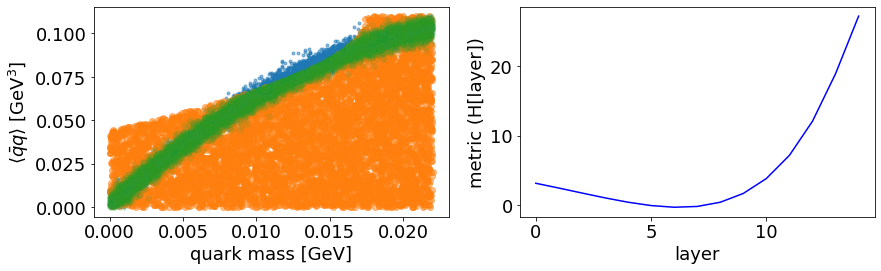

training epoch: 1000,   loss: 0.184023916721344
lambda: -7.00526237487793,   AdS radius: 1.5677090883255005[1/GeV]


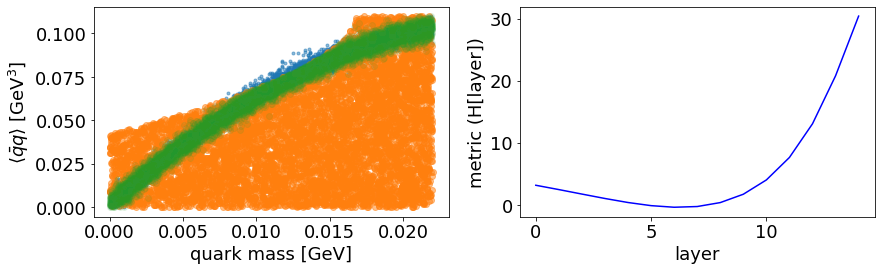

training epoch: 1100,   loss: 0.17990165948867798
lambda: -5.679376125335693,   AdS radius: 1.5754963159561157[1/GeV]


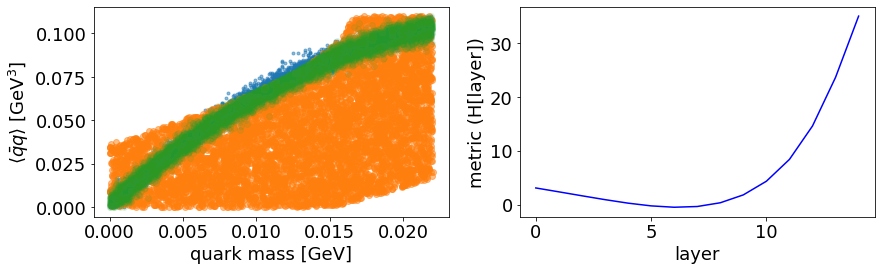

training epoch: 1200,   loss: 0.17048068344593048
lambda: -3.4063167572021484,   AdS radius: 1.646061658859253[1/GeV]


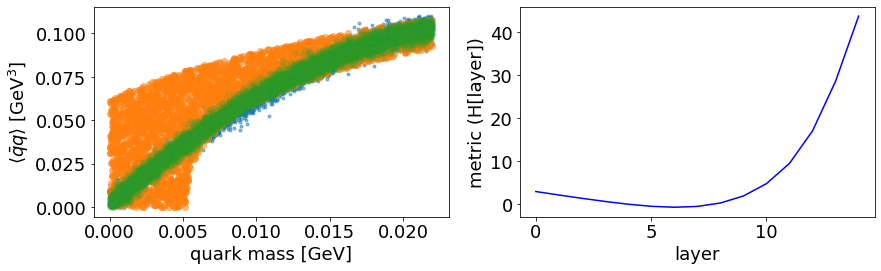

training epoch: 1300,   loss: 0.08380591124296188
lambda: 0.049488313496112823,   AdS radius: 3.0796055793762207[1/GeV]


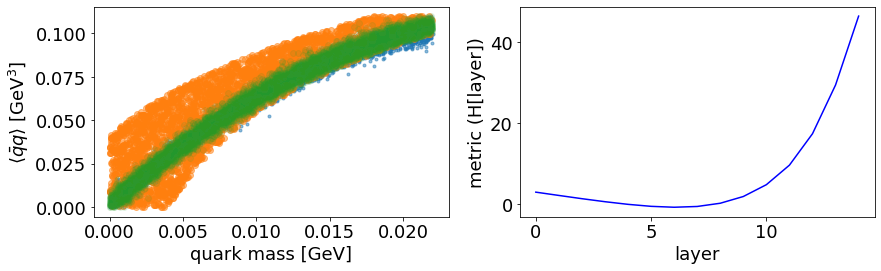

training epoch: 1400,   loss: 0.07555446028709412
lambda: 0.005386673379689455,   AdS radius: 3.715034246444702[1/GeV]


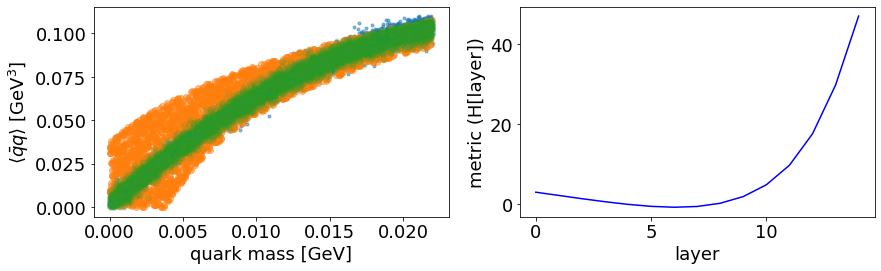

training epoch: 1500,   loss: 0.07524104416370392
lambda: 0.005392736755311489,   AdS radius: 3.860607147216797[1/GeV]


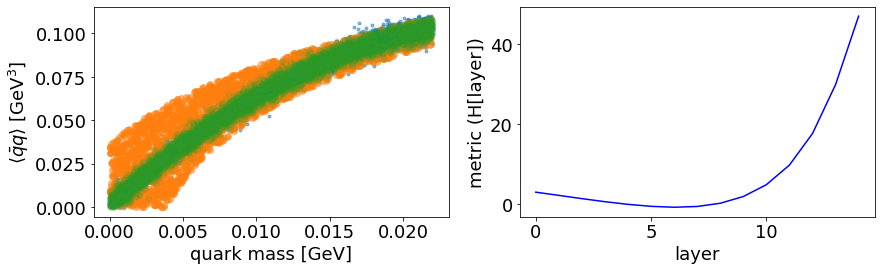

training epoch: 1600,   loss: 0.07470988482236862
lambda: 0.005293580237776041,   AdS radius: 3.8335063457489014[1/GeV]


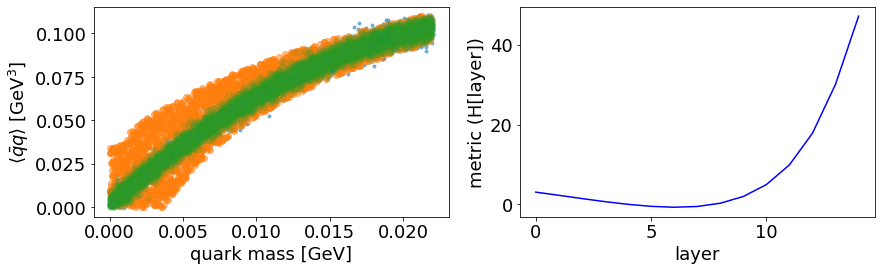

training epoch: 1700,   loss: 0.07449735701084137
lambda: 0.0042777955532073975,   AdS radius: 3.873758316040039[1/GeV]


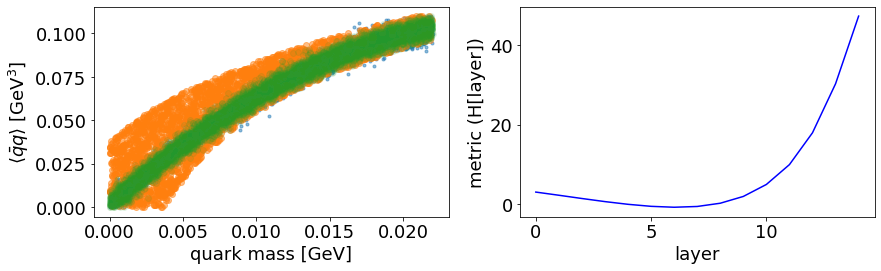

training epoch: 1800,   loss: 0.0753854513168335
lambda: 0.005334650631994009,   AdS radius: 3.7979953289031982[1/GeV]


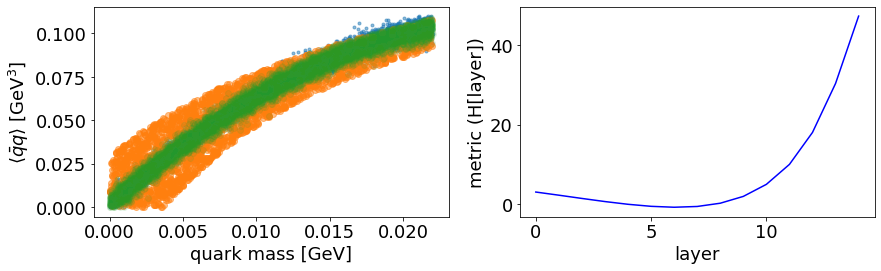

training epoch: 1900,   loss: 0.07498527318239212
lambda: 0.004352659918367863,   AdS radius: 3.8285679817199707[1/GeV]


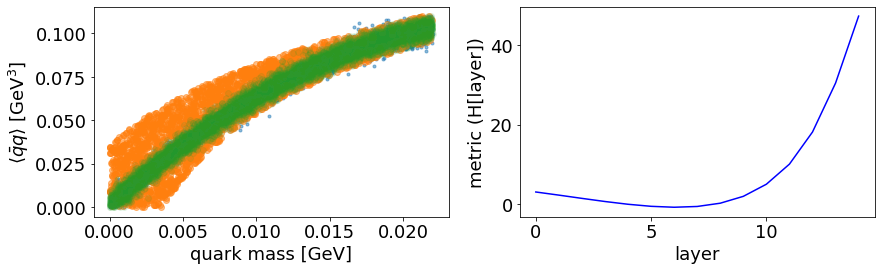

training epoch: 2000,   loss: 0.07485932111740112
lambda: 0.004695306532084942,   AdS radius: 3.852194309234619[1/GeV]


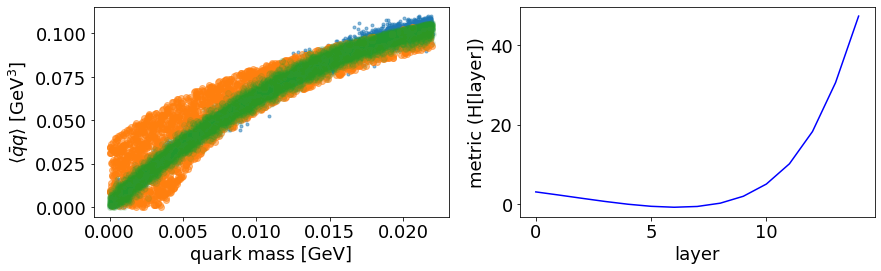

training epoch: 2100,   loss: 0.07434570789337158
lambda: 0.0063640098087489605,   AdS radius: 3.8179121017456055[1/GeV]


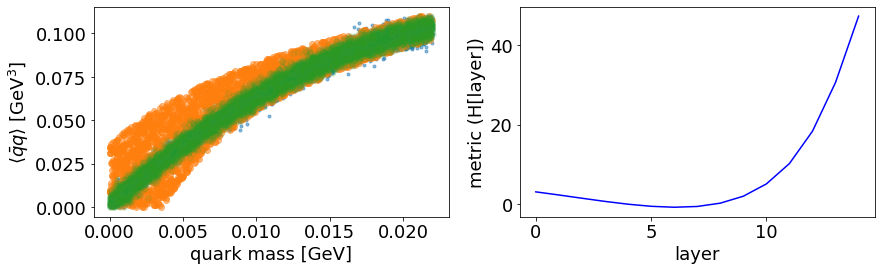

training epoch: 2200,   loss: 0.07431448251008987
lambda: 0.004894070327281952,   AdS radius: 3.8320183753967285[1/GeV]


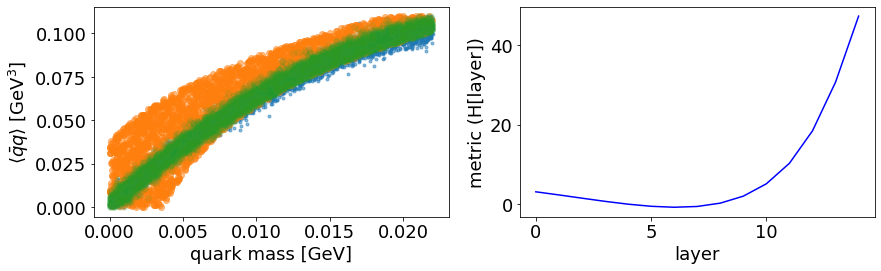

training epoch: 2300,   loss: 0.07464060187339783
lambda: 0.004479600582271814,   AdS radius: 3.830476760864258[1/GeV]


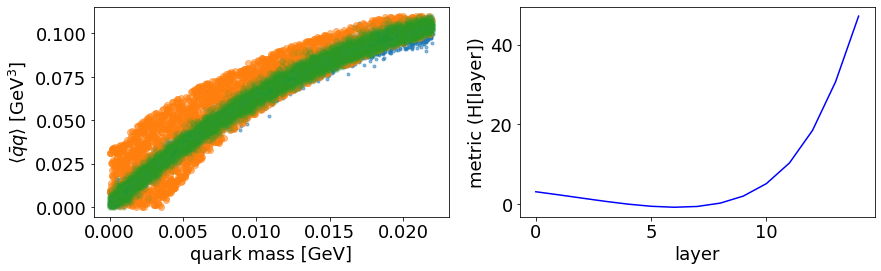

training epoch: 2400,   loss: 0.07477517426013947
lambda: 0.0039961677975952625,   AdS radius: 3.8097527027130127[1/GeV]


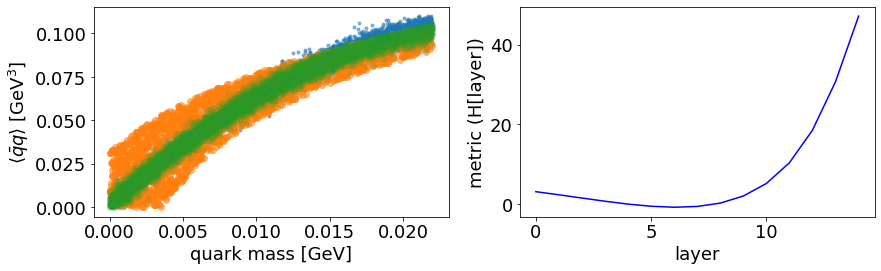

training epoch: 2500,   loss: 0.07445802539587021
lambda: 0.0057300906628370285,   AdS radius: 3.8222732543945312[1/GeV]


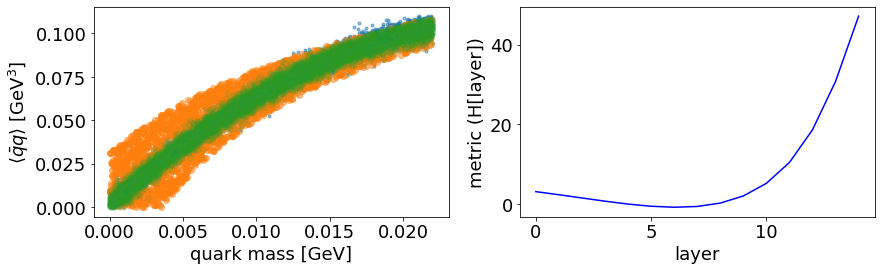

training epoch: 2600,   loss: 0.07594983279705048
lambda: 0.005052614491432905,   AdS radius: 3.7943484783172607[1/GeV]


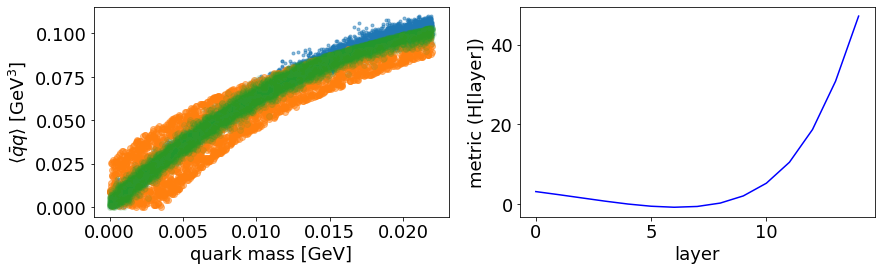

training epoch: 2700,   loss: 0.07751555740833282
lambda: 0.005248755216598511,   AdS radius: 3.794281244277954[1/GeV]


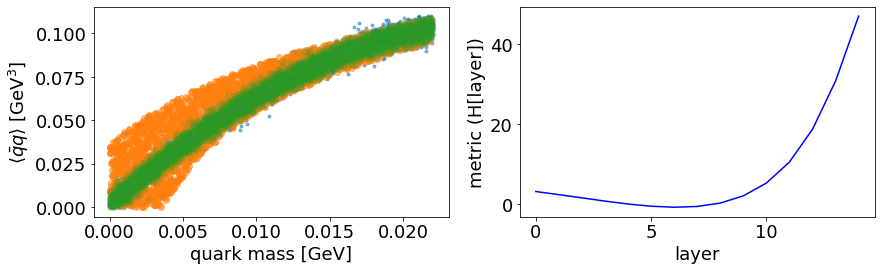

training epoch: 2800,   loss: 0.0741865411400795
lambda: 0.005842171609401703,   AdS radius: 3.7834184169769287[1/GeV]


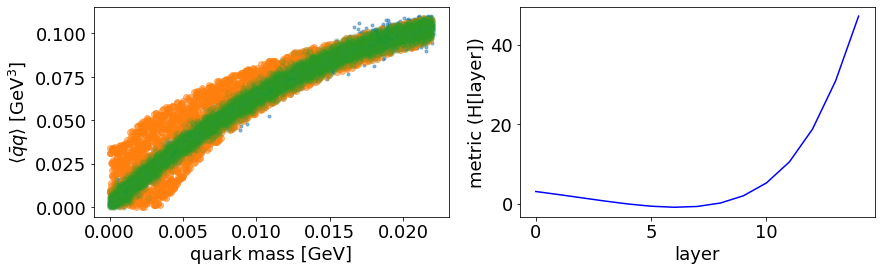

training epoch: 2900,   loss: 0.07500959932804108
lambda: 0.005238469690084457,   AdS radius: 3.8106496334075928[1/GeV]


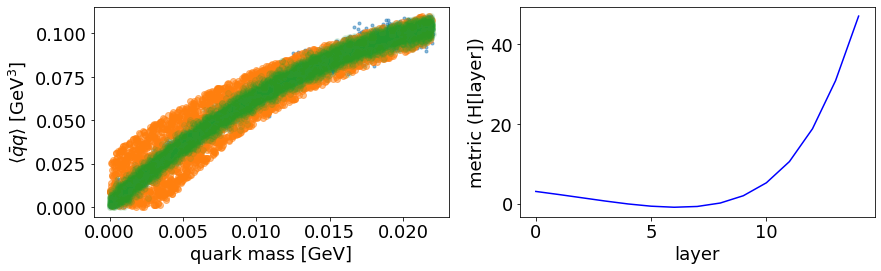

training epoch: 3000,   loss: 0.07476606965065002
lambda: 0.004191546700894833,   AdS radius: 3.796318292617798[1/GeV]


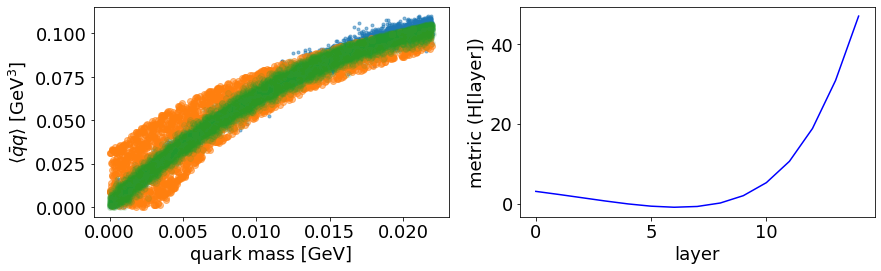

training epoch: 3100,   loss: 0.07337861508131027
lambda: 0.0058703371323645115,   AdS radius: 3.797098159790039[1/GeV]


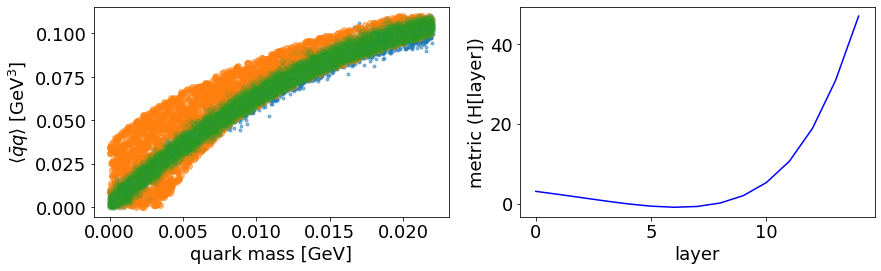

training epoch: 3200,   loss: 0.07561714947223663
lambda: 0.0050287689082324505,   AdS radius: 3.783433437347412[1/GeV]


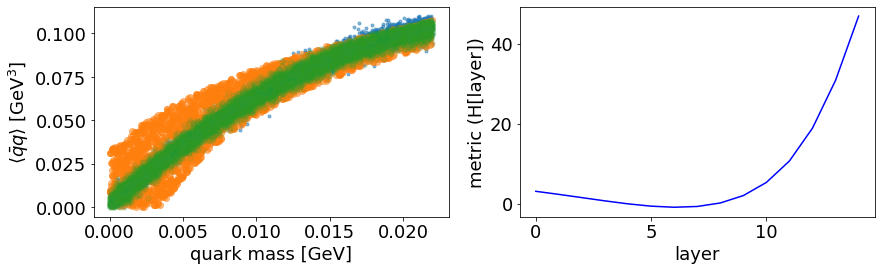

training epoch: 3300,   loss: 0.07394717633724213
lambda: 0.005714959930628538,   AdS radius: 3.7950732707977295[1/GeV]


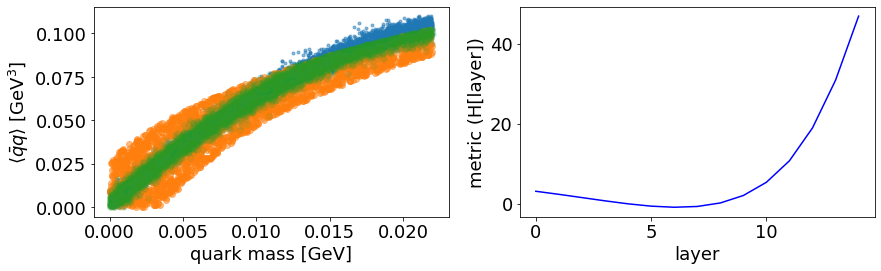

training epoch: 3400,   loss: 0.07405419647693634
lambda: 0.005685429088771343,   AdS radius: 3.79495906829834[1/GeV]


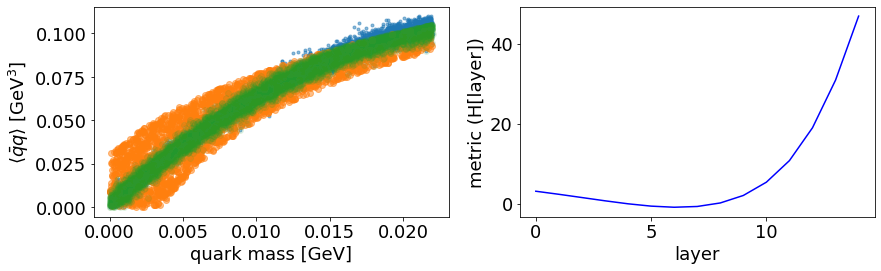

training epoch: 3500,   loss: 0.07416485249996185
lambda: 0.005709628574550152,   AdS radius: 3.7992289066314697[1/GeV]


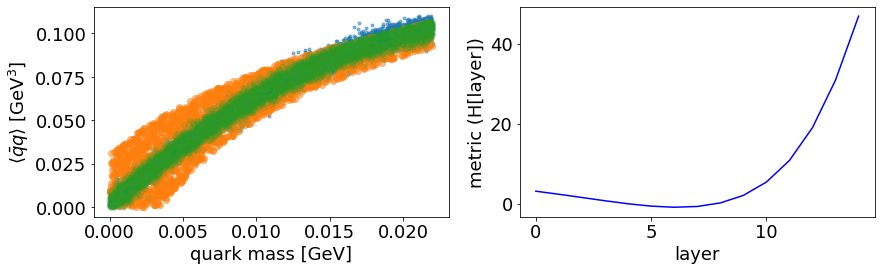

training epoch: 3600,   loss: 0.07466305047273636
lambda: 0.00536874495446682,   AdS radius: 3.7854156494140625[1/GeV]


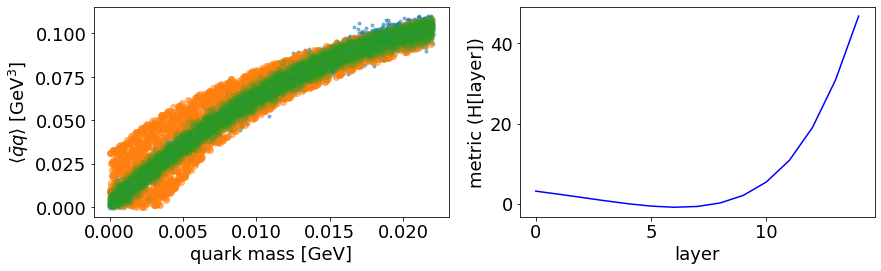

training epoch: 3700,   loss: 0.07541696727275848
lambda: 0.005102242808789015,   AdS radius: 3.79528546333313[1/GeV]


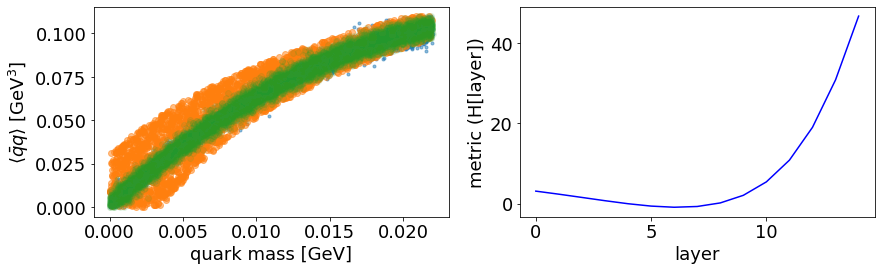

training epoch: 3800,   loss: 0.07390940934419632
lambda: 0.0041764648631215096,   AdS radius: 3.7909598350524902[1/GeV]


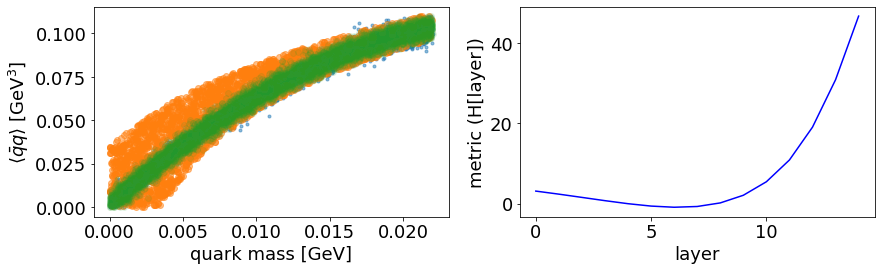

training epoch: 3900,   loss: 0.07395099848508835
lambda: 0.0052963076159358025,   AdS radius: 3.782845973968506[1/GeV]


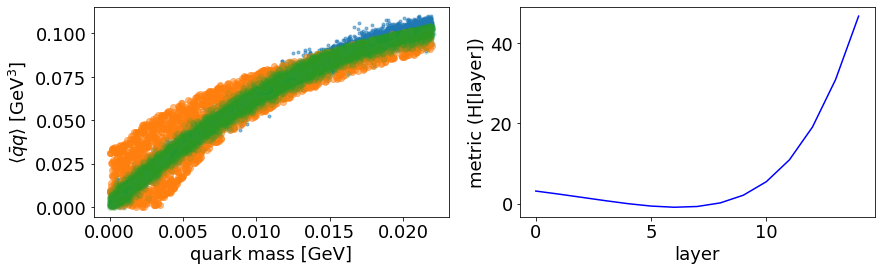

training epoch: 4000,   loss: 0.07324346899986267
lambda: 0.006871087476611137,   AdS radius: 3.7603976726531982[1/GeV]


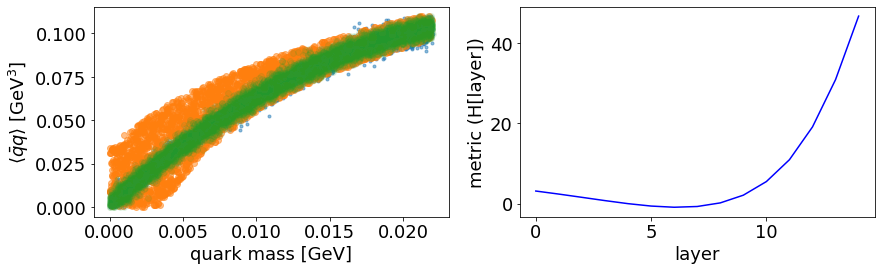

training epoch: 4100,   loss: 0.07338682562112808
lambda: 0.005338355433195829,   AdS radius: 3.7657315731048584[1/GeV]


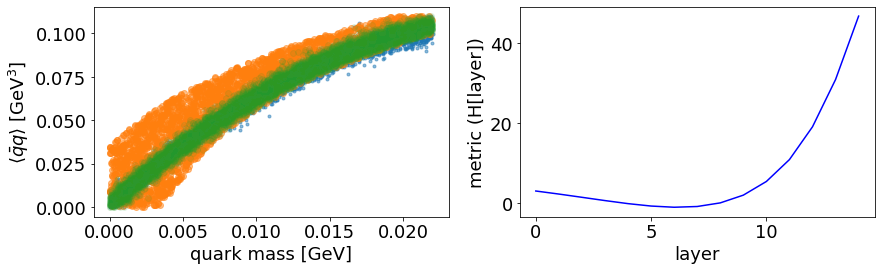

training epoch: 4200,   loss: 0.07422691583633423
lambda: 0.004557013977319002,   AdS radius: 3.788677215576172[1/GeV]


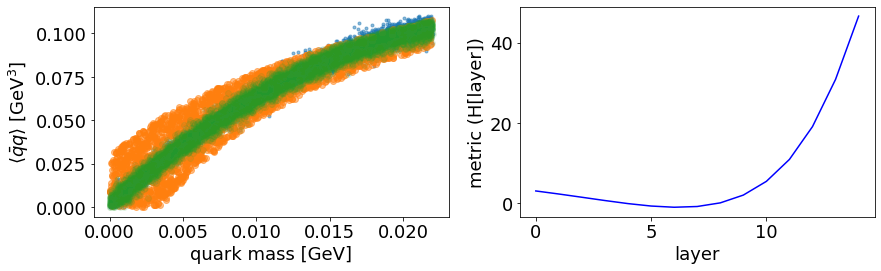

training epoch: 4300,   loss: 0.0742938295006752
lambda: 0.005068221595138311,   AdS radius: 3.783719301223755[1/GeV]


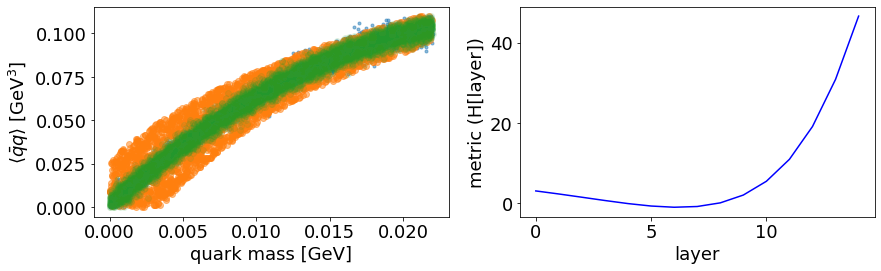

training epoch: 4400,   loss: 0.07617923617362976
lambda: 0.0039060311391949654,   AdS radius: 3.7955150604248047[1/GeV]


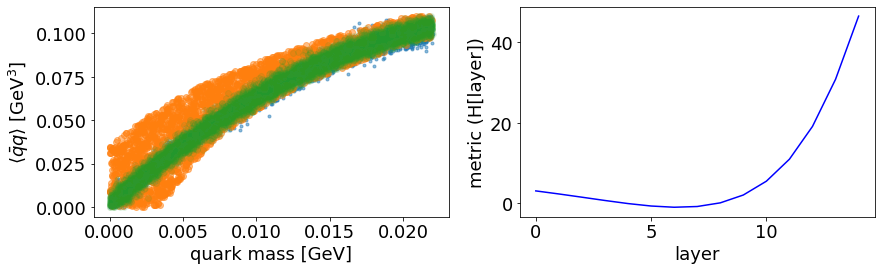

training epoch: 4500,   loss: 0.07370675355195999
lambda: 0.005062357988208532,   AdS radius: 3.7799935340881348[1/GeV]


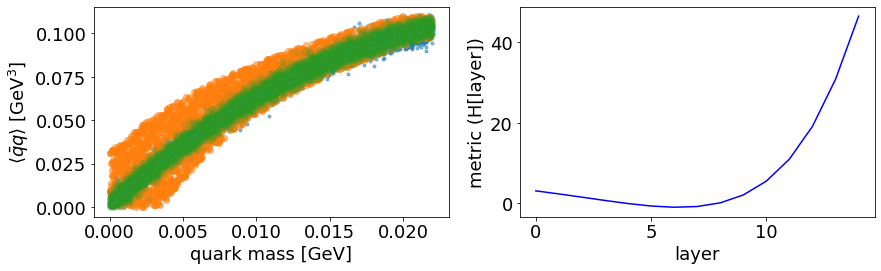

training epoch: 4600,   loss: 0.0746961385011673
lambda: 0.004622933454811573,   AdS radius: 3.758436679840088[1/GeV]


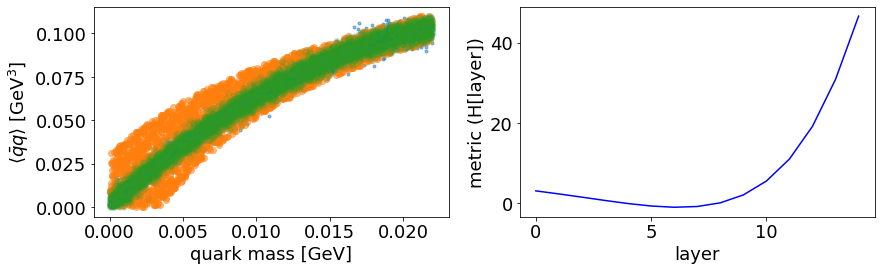

training epoch: 4700,   loss: 0.07353287935256958
lambda: 0.004833189304918051,   AdS radius: 3.7665562629699707[1/GeV]


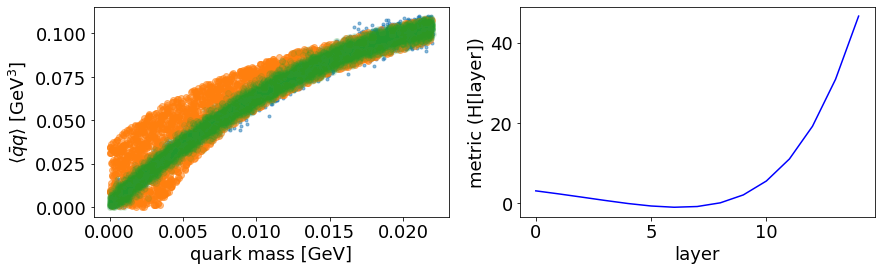

training epoch: 4800,   loss: 0.07460405677556992
lambda: 0.006121722981333733,   AdS radius: 3.76450777053833[1/GeV]


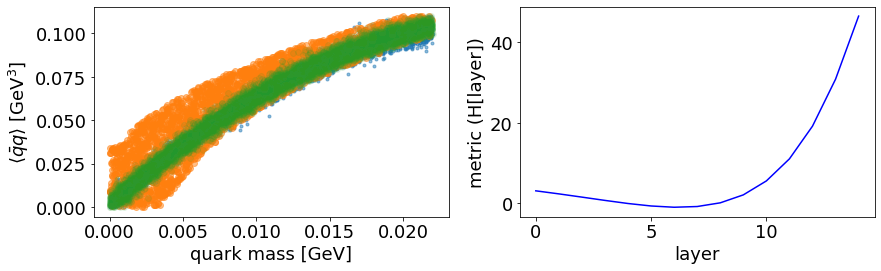

training epoch: 4900,   loss: 0.07369352877140045
lambda: 0.0048003834672272205,   AdS radius: 3.771487236022949[1/GeV]


In [18]:
total_epoch=5000
show_epoch_each=100

for epoch in range(total_epoch):
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        # calclation of loss
        loss = Test.loss(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        # update
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
    

In [21]:
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))

[ 3.1190028e+00  2.3626711e+00  1.5578030e+00  7.3885918e-01
 -3.0531146e-02 -6.4729422e-01 -9.6312952e-01 -7.8423929e-01
  1.3504870e-01  2.1184924e+00  5.5950899e+00  1.1084192e+01
  1.9209127e+01  3.0887457e+01  4.6620293e+01]


# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [0]:
%%bash
mkdir trained_models

mkdir: trained_models: File exists


Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [0]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [0]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [0]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

array([[ 3.85264516]], dtype=float32)

In [0]:
model.lamb.weight.data.numpy() # lambda

array([[ 0.00545012]], dtype=float32)

In [0]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)

[[ 3.13351607]]
[[ 2.39271212]]
[[ 1.60696924]]
[[ 0.8100372]]
[[ 0.06195514]]
[[-0.5439406]]
[[-0.87814671]]
[[-0.77317631]]
[[-0.00735563]]
[[ 1.74285817]]
[[ 4.97534227]]
[[ 10.37840176]]
[[ 18.70586967]]
[[ 30.80181313]]
[[ 46.99329758]]
